# 3. Document Classification Based on BOW


## 1. Preparing the 20 Newsgroups Data and Feature Extraction

 http://scikit-learn.org/0.19/datasets/twenty_newsgroups.html

In [1]:
from sklearn.datasets import fetch_20newsgroups

# Create a list of topics to select from the 20 categories
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

# Fetch the training dataset
newsgroups_train = fetch_20newsgroups(subset='train',
# Remove hinting parts from the email content - classify purely based on content
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

# Fetch the test dataset
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

print('#Train set size:', len(newsgroups_train.data))
print('#Test set size:', len(newsgroups_test.data))
print('#Selected categories:', newsgroups_train.target_names)
print('#Train labels:', set(newsgroups_train.target))

#Train set size: 2034
#Test set size: 1353
#Selected categories: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
#Train labels: {0, 1, 2, 3}


In [2]:
print('#Train set text samples:', newsgroups_train.data[0])
print('#Train set label smaples:', newsgroups_train.target[0])
print('#Test set text samples:', newsgroups_test.data[0])
print('#Test set label smaples:', newsgroups_test.target[0])

#Train set text samples: Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
#Train set label smaples: 1
#Test set text samples: TRry the SKywatch project in  Arizona.
#Test set label smaples: 2


In [3]:
X_train = newsgroups_train.data   # Training dataset documents
y_train = newsgroups_train.target # Training dataset labels

X_test = newsgroups_test.data     # Test dataset documents
y_test = newsgroups_test.target   # Test dataset labels

## 2. Document Representation Based on Distributed Representation

### 1) Word2Vec

In [4]:
# Import necessary libraries for Word2Vec and machine learning models
import gensim
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from nltk.tokenize import word_tokenize
import nltk


# Download required NLTK resources for tokenization and stopwords
nltk.download('punkt')  # For word tokenization
nltk.download('stopwords')  # For filtering out common stopwords

# Initialize a set of stopwords for English and a stemmer to reduce words to their root form
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()  # PorterStemmer is commonly used to reduce words to their stem form

# Data preprocessing function
def preprocess_data(data):
    processed_data = []
    for sentence in data:
        # Tokenize the sentence into words
        tokens = word_tokenize(sentence)
        # Convert to lowercase, remove stopwords and special characters, and apply stemming
        tokens = [stemmer.stem(re.sub(r'\W+', '', word.lower()))
                  for word in tokens
                  if word.lower() not in stop_words and re.sub(r'\W+', '', word)]
        processed_data.append(tokens)  # Add the cleaned tokens to the processed data
    return processed_data

# Step 1: Train the Word2Vec model
# Preprocess the training and testing data using the preprocess_data function
X_train_tokenized = preprocess_data(X_train)
X_test_tokenized = preprocess_data(X_test)

# Flatten the tokenized training data into a single list and calculate word frequency
all_words = [word for sentence in X_train_tokenized for word in sentence]
word_counts = Counter(all_words)  # Count frequency of each word in the training data

# Define a threshold to remove low-frequency words
min_count_threshold = 2  # Words with a frequency of 2 or lower will be removed
# Filter the tokenized training and testing data to keep only frequent words
X_train_tokenized = [[word for word in sentence if word_counts[word] > min_count_threshold] for sentence in X_train_tokenized]
X_test_tokenized = [[word for word in sentence if word_counts[word] > min_count_threshold] for sentence in X_test_tokenized]

# Train the Word2Vec model with the tokenized and filtered training data
# vector_size: Dimensionality of the word vectors
# window: Maximum distance between the current and predicted word
# sg: Use skip-gram (1) instead of CBOW (0)
w2v_model = Word2Vec(sentences=X_train_tokenized, vector_size=100, window=2, min_count=2, sg=1)

# Step 2: Function to generate Word2Vec vectors for each sentence
# Each sentence vector is computed as the average of its word vectors
def get_w2v_vectors(data, model):
    """
    Generate sentence vectors by averaging word vectors from Word2Vec model.
    Automatically uses the vector_size from the model itself.
    """
    vector_size = model.wv.vector_size  # Get vector size directly from the model
    vectors = []
    for sentence in data:
        # Initialize a zero vector for the sentence
        sentence_vec = np.zeros(vector_size)
        count = 0  # Track the number of words found in the Word2Vec model
        for word in sentence:
            # Check if the word exists in the Word2Vec model
            if word in model.wv.key_to_index:
                # Add the word vector to the sentence vector
                sentence_vec += model.wv[word]
                count += 1
        # If the sentence contains valid words, compute the average of the word vectors
        if count != 0:
            # The sentence vector is the average of the word vectors in the sentence
            sentence_vec /= count
        # Append the resulting sentence vector (average of word vectors) to the list
        vectors.append(sentence_vec)
    return np.array(vectors)

# Generate Word2Vec vectors for both the training and testing data
X_train_w2v = get_w2v_vectors(X_train_tokenized, w2v_model)
X_test_w2v = get_w2v_vectors(X_test_tokenized, w2v_model)

# Step 3: Train machine learning models (Logistic Regression and Random Forest)
# Initialize two different classifiers for comparison
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),  # Logistic Regression with maximum iterations set to 1000
    'Random Forest': RandomForestClassifier()  # Random Forest Classifier
}

# Dictionary to store model names and their performance metrics
results = {'Model': [], 'Train Accuracy': [], 'Test Accuracy': []}

# Train each model and evaluate accuracy on the training and testing data
for model_name, model in models.items():
    # Fit the model using the Word2Vec vectorized training data and corresponding labels
    model.fit(X_train_w2v, y_train)
    # Calculate accuracy on both the training and testing datasets
    train_acc = model.score(X_train_w2v, y_train)
    test_acc = model.score(X_test_w2v, y_test)

    # Store the results for each model
    results['Model'].append(model_name + " (Word2Vec)")  # Add the model name and the method used (Word2Vec)
    results['Train Accuracy'].append(train_acc)  # Training accuracy
    results['Test Accuracy'].append(test_acc)  # Testing accuracy

[nltk_data] Downloading package punkt to /Users/itaehwan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/itaehwan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
print(results)

{'Model': ['Logistic Regression (Word2Vec)', 'Random Forest (Word2Vec)'], 'Train Accuracy': [0.6804326450344149, 0.9783677482792527], 'Test Accuracy': [0.6437546193643755, 0.6666666666666666]}


### 2) FastText

In [6]:
# Import FastText from Gensim library and Optuna for hyperparameter optimization
from gensim.models import FastText
import optuna
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

print("FastText with Optuna Hyperparameter Optimization")

# Step 1: Function to generate sentence vectors from FastText models
def get_fasttext_vectors(data, model):
    """
    Generate sentence vectors by averaging word vectors from FastText model.
    Automatically uses the vector_size from the model itself.
    """
    vector_size = model.wv.vector_size  # Get vector size directly from the model
    vectors = []
    for sentence in data:
        # Initialize a zero vector for each sentence
        sentence_vec = np.zeros(vector_size)
        count = 0  # To track how many words in the sentence exist in the model
        for word in sentence:
            # Check if the word exists in the model's vocabulary
            if word in model.wv.key_to_index:
                # Add the word vector to the sentence vector
                sentence_vec += model.wv[word]
                count += 1
        # If there are valid words in the sentence, compute the average word vector
        if count != 0:
            # The sentence vector is the average of the word vectors
            sentence_vec /= count
        # Append the sentence vector to the list
        vectors.append(sentence_vec)
    # Return the list of sentence vectors as a numpy array
    return np.array(vectors)

# Step 2: Optuna optimization function for FastText
def optimize_fasttext(trial):
    """Optuna objective function for FastText hyperparameter optimization"""
    
    # Suggest hyperparameters for FastText
    vector_size = trial.suggest_categorical('vector_size', [50, 100, 150, 200])
    window = trial.suggest_int('window', 3, 10)
    min_count = trial.suggest_int('min_count', 1, 5)
    sg = trial.suggest_categorical('sg', [0, 1])  # 0: CBOW, 1: Skip-gram
    
    # Suggest hyperparameters for Random Forest (best performing classifier)
    n_estimators = trial.suggest_categorical('n_estimators', [50, 100, 200])
    max_depth = trial.suggest_categorical('max_depth', [None, 10, 20, 30])
    
    try:
        # Train FastText with suggested parameters
        ft_model = FastText(
            sentences=X_train_tokenized,
            vector_size=vector_size,
            window=window,
            min_count=min_count,
            sg=sg,
            epochs=5,  # Reduced for speed
            workers=4
        )
        
        # Generate vectors
        X_train_ft = get_fasttext_vectors(X_train_tokenized, ft_model)
        
        # Train Random Forest with suggested parameters
        rf_model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            random_state=42
        )
        
        # Use cross-validation for robust evaluation
        cv_scores = cross_val_score(rf_model, X_train_ft, y_train, cv=3, scoring='accuracy')
        return cv_scores.mean()
    
    except Exception as e:
        return 0.0

# Step 3: Run Optuna optimization
print("Optimizing FastText hyperparameters...")
study = optuna.create_study(direction='maximize')
study.optimize(optimize_fasttext, n_trials=30, show_progress_bar=True)

print(f"Best parameters found! CV Score: {study.best_value:.4f}")
best_params = study.best_params
for key, value in best_params.items():
    print(f"  {key}: {value}")

# Step 4: Train final optimized FastText model
print("\nTraining final optimized FastText model...")
fasttext_model = FastText(
    sentences=X_train_tokenized,
    vector_size=best_params['vector_size'],
    window=best_params['window'],
    min_count=best_params['min_count'],
    sg=best_params['sg'],
    epochs=10,
    workers=4
)

# Generate optimized FastText vectors
X_train_fasttext = get_fasttext_vectors(X_train_tokenized, fasttext_model)
X_test_fasttext = get_fasttext_vectors(X_test_tokenized, fasttext_model)

# Step 5: Train both classifiers with optimized FastText vectors
print("Evaluating optimized FastText with both classifiers...")

# Optimized Random Forest
rf_optimized = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    random_state=42
)
rf_optimized.fit(X_train_fasttext, y_train)
rf_train_acc = rf_optimized.score(X_train_fasttext, y_train)
rf_test_acc = rf_optimized.score(X_test_fasttext, y_test)

# Now optimize Logistic Regression as well for fair comparison
print("\n🎯 Optimizing Logistic Regression for FastText...")
def optimize_lr_fasttext(trial):
    C = trial.suggest_float('C', 0.01, 10.0, log=True)
    max_iter = trial.suggest_categorical('max_iter', [500, 1000, 2000])
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear'])
    try:
        lr = LogisticRegression(C=C, max_iter=max_iter, solver=solver, random_state=42)
        cv_scores = cross_val_score(lr, X_train_fasttext, y_train, cv=3, scoring='accuracy')
        return cv_scores.mean()
    except:
        return 0.0

study_lr_ft = optuna.create_study(direction='maximize')
study_lr_ft.optimize(optimize_lr_fasttext, n_trials=10, show_progress_bar=True)
print(f"✅ Best LR for FastText: CV={study_lr_ft.best_value:.4f}")

# Train optimized Logistic Regression
lr_optimized = LogisticRegression(
    C=study_lr_ft.best_params['C'],
    max_iter=study_lr_ft.best_params['max_iter'],
    solver=study_lr_ft.best_params['solver'],
    random_state=42
)
lr_optimized.fit(X_train_fasttext, y_train)
lr_train_acc = lr_optimized.score(X_train_fasttext, y_train)
lr_test_acc = lr_optimized.score(X_test_fasttext, y_test)

# Store results
results['Model'].append("Logistic Regression (FastText-Optimized)")
results['Train Accuracy'].append(lr_train_acc)
results['Test Accuracy'].append(lr_test_acc)

results['Model'].append("Random Forest (FastText-Optimized)")
results['Train Accuracy'].append(rf_train_acc)
results['Test Accuracy'].append(rf_test_acc)

print(f"\n✅ FastText Results (Both Optimized):")
print(f"   LR: Train={lr_train_acc:.4f}, Test={lr_test_acc:.4f}")
print(f"   RF: Train={rf_train_acc:.4f}, Test={rf_test_acc:.4f}")


[I 2025-10-03 18:33:17,424] A new study created in memory with name: no-name-3eafc4bd-7856-4a68-8ba9-1f19754b595f


FastText with Optuna Hyperparameter Optimization
Optimizing FastText hyperparameters...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-10-03 18:33:24,186] Trial 0 finished with value: 0.7694198623402163 and parameters: {'vector_size': 150, 'window': 10, 'min_count': 2, 'sg': 1, 'n_estimators': 100, 'max_depth': 10}. Best is trial 0 with value: 0.7694198623402163.
[I 2025-10-03 18:33:30,994] Trial 1 finished with value: 0.7448377581120944 and parameters: {'vector_size': 150, 'window': 5, 'min_count': 4, 'sg': 1, 'n_estimators': 200, 'max_depth': 20}. Best is trial 0 with value: 0.7694198623402163.
[I 2025-10-03 18:33:35,071] Trial 2 finished with value: 0.595378564405113 and parameters: {'vector_size': 150, 'window': 4, 'min_count': 3, 'sg': 0, 'n_estimators': 100, 'max_depth': None}. Best is trial 0 with value: 0.7694198623402163.
[I 2025-10-03 18:33:40,117] Trial 3 finished with value: 0.631268436578171 and parameters: {'vector_size': 100, 'window': 8, 'min_count': 2, 'sg': 0, 'n_estimators': 200, 'max_depth': 10}. Best is trial 0 with value: 0.7694198623402163.
[I 2025-10-03 18:33:41,933] Trial 4 finished wi

[I 2025-10-03 18:36:01,708] A new study created in memory with name: no-name-bbf33ebc-4dba-4783-a6ac-94eb22f09fa5



🎯 Optimizing Logistic Regression for FastText...


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2025-10-03 18:36:01,957] Trial 0 finished with value: 0.795968534906588 and parameters: {'C': 4.1673406483019795, 'max_iter': 1000, 'solver': 'liblinear'}. Best is trial 0 with value: 0.795968534906588.
[I 2025-10-03 18:36:02,018] Trial 1 finished with value: 0.7182890855457226 and parameters: {'C': 0.029162888021251856, 'max_iter': 500, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.795968534906588.
[I 2025-10-03 18:36:02,287] Trial 2 finished with value: 0.795968534906588 and parameters: {'C': 4.871224587837689, 'max_iter': 500, 'solver': 'liblinear'}. Best is trial 0 with value: 0.795968534906588.
[I 2025-10-03 18:36:02,477] Trial 3 finished with value: 0.7910521140609635 and parameters: {'C': 0.9757197200140749, 'max_iter': 1000, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.795968534906588.
[I 2025-10-03 18:36:02,558] Trial 4 finished with value: 0.7576204523107178 and parameters: {'C': 0.11268339334975848, 'max_iter': 1000, 'solver': 'lbfgs'}. Best is trial 0 with value

### 3) GloVe

In [7]:
print("\n" + "="*60)
print("GloVe with Optuna Hyperparameter Optimization")
print("="*60)

# Option A: Using glove-python package (if you can install it)
try:
    from glove import Corpus, Glove
    
    # Step 1: Train GloVe model
    # Create a Corpus object that will hold the co-occurrence matrix
    corpus = Corpus()
    
    # Fit the corpus with the tokenized training data
    corpus.fit(X_train_tokenized, window=5)
    
    # Initialize the GloVe model
    glove_model = Glove(no_components=100, learning_rate=0.05)
    
    # Train the GloVe model using the co-occurrence matrix
    glove_model.fit(corpus.matrix, epochs=10, no_threads=4, verbose=True)
    
    # Add the word dictionary from the corpus to the GloVe model
    glove_model.add_dictionary(corpus.dictionary)
    
    # Step 2: Function to generate sentence vectors from GloVe model
    def get_glove_vectors(data, model, dictionary, vector_size=100):
        vectors = []
        for sentence in data:
            sentence_vec = np.zeros(vector_size)
            count = 0
            for word in sentence:
                if word in dictionary:
                    sentence_vec += model.word_vectors[dictionary[word]]
                    count += 1
            if count != 0:
                sentence_vec /= count
            vectors.append(sentence_vec)
        return np.array(vectors)
    
    # Generate GloVe vectors for both training and testing data
    X_train_glove = get_glove_vectors(X_train_tokenized, glove_model, corpus.dictionary)
    X_test_glove = get_glove_vectors(X_test_tokenized, glove_model, corpus.dictionary)
    
    print("✓ GloVe model trained successfully using glove-python!")

except ImportError:
    print("✗ glove-python not installed. Using alternative: Pre-trained GloVe vectors")
    
    # Option B: Using pre-trained GloVe vectors (more stable)
    import os
    import urllib.request
    from gensim.models import KeyedVectors
    
    # Download GloVe pre-trained vectors
    glove_url = 'http://nlp.stanford.edu/data/glove.6B.zip'
    glove_file = 'glove.6B.100d.txt'
    glove_word2vec_file = 'glove.6B.100d.word2vec.txt'
    
    # Check if GloVe file exists, if not download it
    if not os.path.exists(glove_file):
        print("Downloading pre-trained GloVe vectors... (this may take a while)")
        import zipfile
        urllib.request.urlretrieve(glove_url, 'glove.6B.zip')
        with zipfile.ZipFile('glove.6B.zip', 'r') as zip_ref:
            zip_ref.extractall('.')
        print("✓ GloVe vectors downloaded successfully!")
    
    # Convert GloVe format to Word2Vec format (using direct loading)
    if not os.path.exists(glove_word2vec_file):
        print("Converting GloVe format to Word2Vec format...")
        # Read GloVe file and add header for Word2Vec format
        with open(glove_file, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        
        # Write Word2Vec format file with header
        with open(glove_word2vec_file, 'w', encoding='utf-8') as f:
            f.write(f"{len(lines)} 100\n")  # Add header: vocab_size vector_size
            f.writelines(lines)
    
    # Load GloVe model
    print("Loading pre-trained GloVe model...")
    glove_model_kv = KeyedVectors.load_word2vec_format(glove_word2vec_file, binary=False)
    
    # Function to generate sentence vectors from pre-trained GloVe
    def get_pretrained_glove_vectors(data, model, vector_size=100):
        vectors = []
        for sentence in data:
            sentence_vec = np.zeros(vector_size)
            count = 0
            for word in sentence:
                if word in model:
                    sentence_vec += model[word]
                    count += 1
            if count != 0:
                sentence_vec /= count
            vectors.append(sentence_vec)
        return np.array(vectors)
    
    # Generate GloVe vectors
    X_train_glove = get_pretrained_glove_vectors(X_train_tokenized, glove_model_kv)
    X_test_glove = get_pretrained_glove_vectors(X_test_tokenized, glove_model_kv)
    
    print("✓ Using pre-trained GloVe vectors!")

# Helper function to load different GloVe dimensions
def load_glove_model_by_dimension(dimension):
    """Load GloVe model with specified dimension (50, 100, 200, or 300)"""
    import os
    from gensim.models import KeyedVectors
    
    glove_file = f'glove.6B.{dimension}d.txt'
    glove_word2vec_file = f'glove.6B.{dimension}d.word2vec.txt'
    
    # Ensure files exist
    if not os.path.exists(glove_file):
        print(f"⚠️ {glove_file} not found! Using existing model.")
        return None
    
    # Convert GloVe format to Word2Vec format if needed
    if not os.path.exists(glove_word2vec_file):
        print(f"Converting GloVe {dimension}d to Word2Vec format...")
        with open(glove_file, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        with open(glove_word2vec_file, 'w', encoding='utf-8') as f:
            f.write(f"{len(lines)} {dimension}\n")
            f.writelines(lines)
    
    return KeyedVectors.load_word2vec_format(glove_word2vec_file, binary=False)

# Step 3: Optuna optimization for GloVe (including embedding dimension)
def optimize_glove_classifier(trial):
    """Optuna objective function for GloVe classifier optimization (with dimension selection)"""
    
    # Suggest GloVe embedding dimension (50, 100, 200, 300)
    dimension = trial.suggest_categorical('glove_dimension', [50, 100, 200, 300])
    
    # Suggest hyperparameters for Logistic Regression
    C = trial.suggest_float('C', 0.01, 10.0, log=True)
    max_iter = trial.suggest_categorical('max_iter', [500, 1000, 2000])
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear'])
    
    try:
        # Load GloVe model with specified dimension
        glove_model_trial = load_glove_model_by_dimension(dimension)
        if glove_model_trial is None:
            return 0.0
        
        # Generate vectors with selected dimension
        X_train_temp = get_pretrained_glove_vectors(X_train_tokenized, glove_model_trial)
        
        # Train Logistic Regression with suggested parameters
        lr_model = LogisticRegression(
            C=C, 
            max_iter=max_iter, 
            solver=solver,
            random_state=42
        )
        
        # Use cross-validation for robust evaluation
        cv_scores = cross_val_score(lr_model, X_train_temp, y_train, cv=3, scoring='accuracy')
        return cv_scores.mean()
    
    except Exception as e:
        return 0.0

print("🎯 Optimizing GloVe hyperparameters (including embedding dimension: 50d/100d/200d/300d)...")
study_glove = optuna.create_study(direction='maximize')
study_glove.optimize(optimize_glove_classifier, n_trials=30, show_progress_bar=True)

print(f"✅ Best GloVe parameters found! CV Score: {study_glove.best_value:.4f}")
best_glove_params = study_glove.best_params
for key, value in best_glove_params.items():
    print(f"  {key}: {value}")

# Step 4: Load the optimal GloVe model and generate vectors
print(f"\n📥 Loading optimized GloVe model ({best_glove_params['glove_dimension']}d)...")
glove_model_optimized = load_glove_model_by_dimension(best_glove_params['glove_dimension'])
X_train_glove_optimized = get_pretrained_glove_vectors(X_train_tokenized, glove_model_optimized)
X_test_glove_optimized = get_pretrained_glove_vectors(X_test_tokenized, glove_model_optimized)
print(f"✅ Using optimized GloVe {best_glove_params['glove_dimension']}d embeddings!")

# Step 5: Model training and performance evaluation with optimized GloVe
print("\n📊 Evaluating optimized GloVe with both classifiers...")

# Optimized Logistic Regression
lr_optimized = LogisticRegression(
    C=best_glove_params['C'],
    max_iter=best_glove_params['max_iter'],
    solver=best_glove_params['solver'],
    random_state=42
)
lr_optimized.fit(X_train_glove_optimized, y_train)
lr_train_acc = lr_optimized.score(X_train_glove_optimized, y_train)
lr_test_acc = lr_optimized.score(X_test_glove_optimized, y_test)

# Now optimize Random Forest as well for fair comparison
print("\n🎯 Optimizing Random Forest for GloVe...")
def optimize_rf_glove(trial):
    n_estimators = trial.suggest_categorical('n_estimators', [50, 100, 200])
    max_depth = trial.suggest_categorical('max_depth', [None, 10, 20, 30])
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    try:
        rf = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42
        )
        cv_scores = cross_val_score(rf, X_train_glove_optimized, y_train, cv=3, scoring='accuracy')
        return cv_scores.mean()
    except:
        return 0.0

study_rf_glove = optuna.create_study(direction='maximize')
study_rf_glove.optimize(optimize_rf_glove, n_trials=30, show_progress_bar=True)
print(f"✅ Best RF for GloVe: CV={study_rf_glove.best_value:.4f}")

# Train optimized Random Forest
rf_optimized = RandomForestClassifier(
    n_estimators=study_rf_glove.best_params['n_estimators'],
    max_depth=study_rf_glove.best_params['max_depth'],
    min_samples_split=study_rf_glove.best_params['min_samples_split'],
    random_state=42
)
rf_optimized.fit(X_train_glove_optimized, y_train)
rf_train_acc = rf_optimized.score(X_train_glove_optimized, y_train)
rf_test_acc = rf_optimized.score(X_test_glove_optimized, y_test)

# Store results
results['Model'].append("Logistic Regression (GloVe-Optimized)")
results['Train Accuracy'].append(lr_train_acc)
results['Test Accuracy'].append(lr_test_acc)

results['Model'].append("Random Forest (GloVe-Optimized)")
results['Train Accuracy'].append(rf_train_acc)
results['Test Accuracy'].append(rf_test_acc)

print(f"\n✅ GloVe Results (Dimension: {best_glove_params['glove_dimension']}d, Both Classifiers Optimized):")
print(f"   LR: Train={lr_train_acc:.4f}, Test={lr_test_acc:.4f}")
print(f"   RF: Train={rf_train_acc:.4f}, Test={rf_test_acc:.4f}")
print(f"\n🎉 GloVe optimization completed! Best dimension: {best_glove_params['glove_dimension']}d")


GloVe with Optuna Hyperparameter Optimization
✗ glove-python not installed. Using alternative: Pre-trained GloVe vectors
Loading pre-trained GloVe model...


[I 2025-10-03 18:38:28,546] A new study created in memory with name: no-name-e4bc4c56-595b-455d-80ad-acb8f0cbd2b5


✓ Using pre-trained GloVe vectors!
🎯 Optimizing GloVe hyperparameters (including embedding dimension: 50d/100d/200d/300d)...


  0%|          | 0/30 [00:00<?, ?it/s]

Converting GloVe 50d to Word2Vec format...
[I 2025-10-03 18:38:33,967] Trial 0 finished with value: 0.0 and parameters: {'glove_dimension': 50, 'C': 2.6135187309453496, 'max_iter': 500, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2025-10-03 18:38:38,984] Trial 1 finished with value: 0.0 and parameters: {'glove_dimension': 50, 'C': 7.4863518677490095, 'max_iter': 2000, 'solver': 'liblinear'}. Best is trial 0 with value: 0.0.
[I 2025-10-03 18:38:43,745] Trial 2 finished with value: 0.0 and parameters: {'glove_dimension': 50, 'C': 3.3607575858344902, 'max_iter': 500, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.0.
Converting GloVe 200d to Word2Vec format...
[I 2025-10-03 18:39:03,159] Trial 3 finished with value: 0.0 and parameters: {'glove_dimension': 200, 'C': 0.20303616738018557, 'max_iter': 1000, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.0.
[I 2025-10-03 18:39:20,379] Trial 4 finished with value: 0.0 and parameters: {'glove_dimension': 200, 'C': 1.06104319

[I 2025-10-03 18:44:41,184] A new study created in memory with name: no-name-c3ad4cbd-5032-44d3-b0fd-fe5055330b1c


✅ Using optimized GloVe 100d embeddings!

📊 Evaluating optimized GloVe with both classifiers...

🎯 Optimizing Random Forest for GloVe...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-10-03 18:44:44,376] Trial 0 finished with value: 0.7222222222222222 and parameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2}. Best is trial 0 with value: 0.7222222222222222.
[I 2025-10-03 18:44:45,806] Trial 1 finished with value: 0.7084562438544739 and parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 6}. Best is trial 0 with value: 0.7222222222222222.
[I 2025-10-03 18:44:47,240] Trial 2 finished with value: 0.711897738446411 and parameters: {'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 9}. Best is trial 0 with value: 0.7222222222222222.
[I 2025-10-03 18:44:50,023] Trial 3 finished with value: 0.7217305801376598 and parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 10}. Best is trial 0 with value: 0.7222222222222222.
[I 2025-10-03 18:44:52,859] Trial 4 finished with value: 0.7212389380530974 and parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 9}. Best is trial 0 with val


🏆 FINAL RESULTS COMPARISON: Word2Vec vs FastText vs GloVe
📊 Complete Performance Comparison:
                                   Model  Train Accuracy  Test Accuracy
Logistic Regression (FastText-Optimized)          0.8432         0.7295
      Random Forest (FastText-Optimized)          0.9730         0.7228
   Logistic Regression (GloVe-Optimized)          0.7827         0.6822
                Random Forest (Word2Vec)          0.9784         0.6667
         Random Forest (GloVe-Optimized)          0.9739         0.6667
          Logistic Regression (Word2Vec)          0.6804         0.6438

🚀 OPTIMIZATION IMPACT:
Best Baseline Test Accuracy: 0.6667
Best Optimized Test Accuracy: 0.7295
Performance Improvement: +9.42%

🎯 Best performing model: Logistic Regression (FastText-Optimized)
🏆 Final Test Accuracy: 0.7295


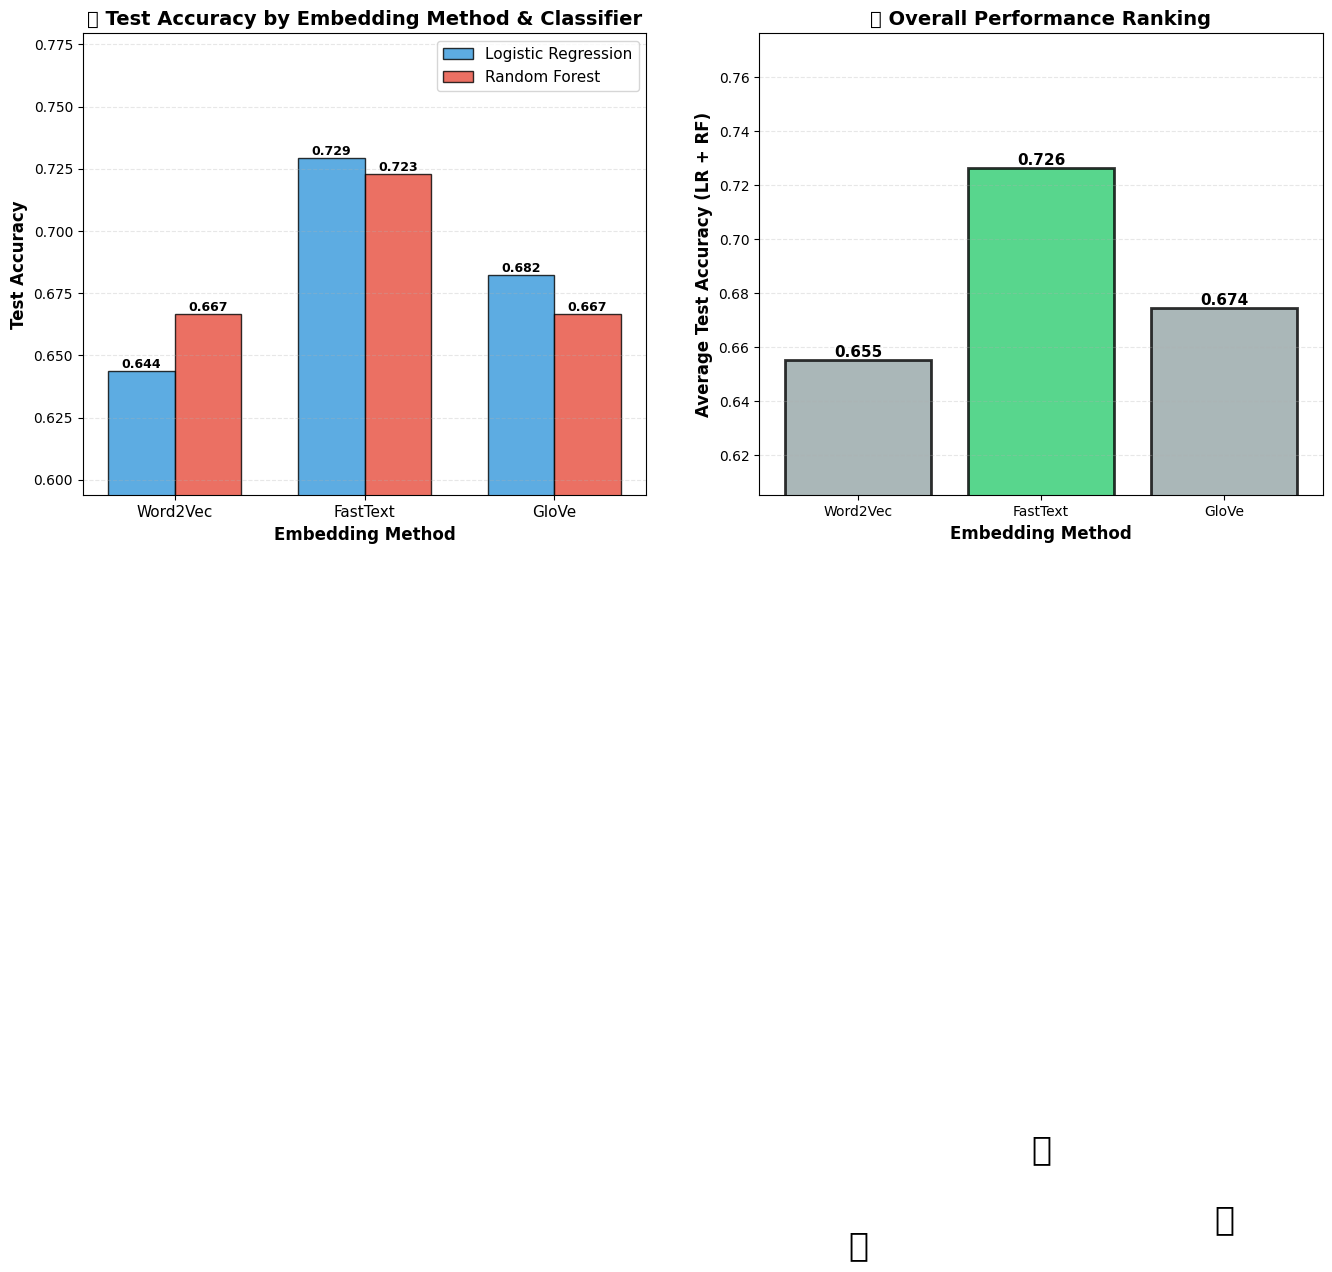


📈 SUMMARY STATISTICS:
Embedding Method LR Accuracy     RF Accuracy     Average         Best Classifier
Word2Vec        0.6438          0.6667          0.6552          RF
FastText        0.7295          0.7228          0.7262          LR
GloVe           0.6822          0.6667          0.6744          LR

🎉 Document Classification with Distributed Representations completed!
📝 Total models evaluated: 6


,Model,Train Accuracy,Test Accuracy
0,Logistic Regression (FastText-Optimized),0.843166,0.729490
1,Random Forest (FastText-Optimized),0.972960,0.722838
2,Logistic Regression (GloVe-Optimized),0.782694,0.682188
3,Random Forest (Word2Vec),0.978368,0.666667
4,Random Forest (GloVe-Optimized),0.973943,0.666667
5,Logistic Regression (Word2Vec),0.680433,0.643755


In [8]:
print("\n" + "="*80)
print("🏆 FINAL RESULTS COMPARISON: Word2Vec vs FastText vs GloVe")
print("="*80)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create comprehensive results DataFrame
results_df = pd.DataFrame(results)

# Sort by test accuracy for better visualization
results_df_sorted = results_df.sort_values('Test Accuracy', ascending=False).reset_index(drop=True)

print("📊 Complete Performance Comparison:")
print(results_df_sorted.to_string(index=False, float_format='%.4f'))

# Calculate performance improvements
baseline_models = [model for model in results['Model'] if 'Optimized' not in model]
optimized_models = [model for model in results['Model'] if 'Optimized' in model]

if optimized_models:
    baseline_best = max([acc for model, acc in zip(results['Model'], results['Test Accuracy']) if 'Optimized' not in model])
    optimized_best = max([acc for model, acc in zip(results['Model'], results['Test Accuracy']) if 'Optimized' in model])
    improvement = ((optimized_best - baseline_best) / baseline_best) * 100
    
    print(f"\n🚀 OPTIMIZATION IMPACT:")
    print(f"Best Baseline Test Accuracy: {baseline_best:.4f}")
    print(f"Best Optimized Test Accuracy: {optimized_best:.4f}")
    print(f"Performance Improvement: {improvement:+.2f}%")

print(f"\n🎯 Best performing model: {results_df_sorted.iloc[0]['Model']}")
print(f"🏆 Final Test Accuracy: {results_df_sorted.iloc[0]['Test Accuracy']:.4f}")

# ============================================================================
# 📊 VISUALIZATION: Compare Word2Vec, FastText, and GloVe
# ============================================================================

# Prepare data for visualization
embedding_methods = []
classifiers = []
test_accuracies = []

for model, test_acc in zip(results['Model'], results['Test Accuracy']):
    # Extract embedding method
    if 'Word2Vec' in model:
        emb = 'Word2Vec'
    elif 'FastText' in model:
        emb = 'FastText'
    elif 'GloVe' in model:
        emb = 'GloVe'
    else:
        continue
    
    # Extract classifier
    if 'Logistic Regression' in model:
        clf = 'LR'
    elif 'Random Forest' in model:
        clf = 'RF'
    else:
        continue
    
    embedding_methods.append(emb)
    classifiers.append(clf)
    test_accuracies.append(test_acc)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Grouped Bar Chart - Embedding Methods Comparison
ax1 = axes[0]
methods = ['Word2Vec', 'FastText', 'GloVe']
lr_scores = []
rf_scores = []

for method in methods:
    lr_score = [acc for emb, clf, acc in zip(embedding_methods, classifiers, test_accuracies) 
                if emb == method and clf == 'LR']
    rf_score = [acc for emb, clf, acc in zip(embedding_methods, classifiers, test_accuracies) 
                if emb == method and clf == 'RF']
    lr_scores.append(lr_score[0] if lr_score else 0)
    rf_scores.append(rf_score[0] if rf_score else 0)

x = np.arange(len(methods))
width = 0.35

bars1 = ax1.bar(x - width/2, lr_scores, width, label='Logistic Regression', 
                color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x + width/2, rf_scores, width, label='Random Forest', 
                color='#e74c3c', alpha=0.8, edgecolor='black')

ax1.set_xlabel('Embedding Method', fontsize=12, fontweight='bold')
ax1.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('🎯 Test Accuracy by Embedding Method & Classifier', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(methods, fontsize=11)
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim([min(test_accuracies) - 0.05, max(test_accuracies) + 0.05])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 2: Overall Performance Comparison
ax2 = axes[1]
avg_scores = [(lr + rf) / 2 for lr, rf in zip(lr_scores, rf_scores)]
colors = ['#2ecc71' if score == max(avg_scores) else '#95a5a6' for score in avg_scores]

bars = ax2.bar(methods, avg_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax2.set_xlabel('Embedding Method', fontsize=12, fontweight='bold')
ax2.set_ylabel('Average Test Accuracy (LR + RF)', fontsize=12, fontweight='bold')
ax2.set_title('🏆 Overall Performance Ranking', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_ylim([min(avg_scores) - 0.05, max(avg_scores) + 0.05])

# Add value labels and ranking
for i, (bar, score) in enumerate(zip(bars, avg_scores)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
    # Add ranking emoji
    rank_emoji = '🥇' if score == max(avg_scores) else ('🥈' if score == sorted(avg_scores, reverse=True)[1] else '🥉')
    ax2.text(bar.get_x() + bar.get_width()/2., height/2,
            rank_emoji, ha='center', va='center', fontsize=24)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n📈 SUMMARY STATISTICS:")
print(f"{'Embedding Method':<15} {'LR Accuracy':<15} {'RF Accuracy':<15} {'Average':<15} {'Best Classifier'}")
print("="*75)
for method, lr, rf in zip(methods, lr_scores, rf_scores):
    avg = (lr + rf) / 2
    best = 'LR' if lr > rf else 'RF'
    print(f"{method:<15} {lr:<15.4f} {rf:<15.4f} {avg:<15.4f} {best}")

print(f"\n🎉 Document Classification with Distributed Representations completed!")
print(f"📝 Total models evaluated: {len(results['Model'])}")

# Display the final results table
results_df_sorted

